In [40]:
# work environment: jl2815
# Standard libraries
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle
import os


import matplotlib.pyplot as plt
from matplotlib import cm  # Colormap module  # Create a colormap (e.g., 'viridis' or 'plasma')

from skgstat import Variogram
from scipy.spatial.distance import pdist, squareform

from typing import Callable   # nearest neighbor function input type



# Summary

In this experiment, we assess how the Vecchia approximation is accurate by comparing two normalized values:

$ \frac{ Prediction(full)- \mu(full)} {\sigma(full)}$ vs $ \frac{ Prediction(full) - \mu(vecchia)} {\sigma(vecchia)}.$

To elaborate on second term; if $x_j$ is conditioned on $x_{i1},...,x_{i10},$ then I use these 10 points to calculate the coefficient for BLP and others instead of using the entire $x_1,..., x_{j-1}, x_{j+1},..., x_n$.

First one is supposed to be normal, and if the vecchia approximation is good enough approximating the full covariance structure, then we expect the second to be nearly standard normal as well. 

However that is not the case. This is because Vecchia approximation results in smaller standard deviation because it chooses the most relevant set as conditioning set, not the entire past data. 

--> Based on this experiment, I plan to clip the conditional standard deviation by  max(sd, 7), where 7 represents the general conditional standard deviation. 

#### Data setup

I picked a time with 20,000 data points. Then I chose a coarse set by choosing every 5th point both in latitude and longitude resulting in 800 data points. 

In [74]:
lat_lon_resolution = [4,4]
mm_cond_number = 10
params= [60, 5.25, 5.25, 0.2, 0.5, 5]
key_for_dict= 8


# Load the one dictionary to set spaital coordinates
filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


key_for_dict= 31
keys = sorted(coarse_dicts)
analysis_data_map = {}
for i in range(0, key_for_dict):
    if i >0:
        cur = coarse_dicts[keys[i]].copy()
        lag = coarse_dicts[keys[i-1]].copy()
        cur.loc[:, 'ColumnAmountO3'] = cur.loc[:, 'ColumnAmountO3']- lag.loc[:, 'ColumnAmountO3']
        cur['Hours_elapsed'] = np.round(cur['Hours_elapsed'])
        # tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
        cur = cur.iloc[ord_mm, :4]
        analysis_data_map[keys[i]] = cur.reset_index(drop=True)  
    else:
        cur = coarse_dicts[keys[i]].copy()
        cur['Hours_elapsed'] = np.round(cur['Hours_elapsed'])
        # tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
        cur = cur.iloc[ord_mm, :4]
        analysis_data_map[keys[i]] = cur.reset_index(drop=True)





Difference data by one lag

In [80]:
class timeseries:
    def __init__(self, map: dict, year: str, month: int, output_dir: str):
        self.map = map
        self.year = year
        self.month = month
        self.output_dir = output_dir

    def var_timeseries_month(self):
        var_timeseries = []

        # Generate variance and month markers
        for _, key in enumerate(self.map.keys()):
            cur = self.map[key]
            var_timeseries.append(np.var(cur['ColumnAmountO3']))

        return var_timeseries
     
    def sem_timeseries_month(self, sem_lag=0.2, tolerance=0.02):

        sem_timeseries = []
        sem_lag = 0.2
        tolerance = 0.02

        # Generate semivariograms and day markers
        for _, key in enumerate(self.map.keys()):
            cur = self.map[key]
            coordinates = np.array(cur[['Latitude', 'Longitude']])
            values = np.array(cur['ColumnAmountO3'])
            pairwise_distances = squareform(pdist(coordinates))
            valid_pairs = np.where((pairwise_distances >= sem_lag - tolerance) &
                                    (pairwise_distances <= sem_lag + tolerance))

            if len(valid_pairs[0]) == 0:
                sem_timeseries.append(np.nan)
                continue
            
            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)
            sem_timeseries.append(semivariances)

        return sem_timeseries
    
    def map_separation(self):
        '''  
        this method creates 4 maps: West, East, North and South. 
        In this method, I clipped data ozone values between 150 and 300. 
        '''
        coarse_dict = {}
        for key in self.map:
            cur = self.map[key].copy()

            ## we need to remove outliars
            mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
            filtered_data = cur[~mask].reset_index(drop=True)

            # Handle cases where the filtered DataFrame is empty
            if filtered_data.empty:
                print(f"Warning: No valid data for key {key}. Skipping.")
                continue
            coarse_dict[key] = filtered_data

        coarse_map_left = {}
        coarse_map_right = {}
        coarse_map_north = {}
        coarse_map_south = {}

        keys = sorted(coarse_dict.keys())
        lat_s, lat_e, lon_s, lon_e = 5, 10, 110, 120
        mid_lon = np.mean([lon_s, lon_e])
        mid_lat = np.mean([lat_s, lat_e])

        
        for key in keys:
            data = coarse_dict[key]
            coarse_map_left[key] = data[data['Longitude'] <= mid_lon]
            coarse_map_right[key] = data[data['Longitude'] > mid_lon]
            coarse_map_north[key] = data[data['Latitude'] > mid_lat]
            coarse_map_south[key] = data[data['Latitude'] <= mid_lat]

        self.coarse_dict = coarse_dict

        return coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south

    def compute_sem_var(self):
        """
        Compute variances and semivariograms for spatially divided submaps.
        Most of the computation time will be spent here.
        """
        coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south = self.map_separation()
        coarse_maps = [coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south]
        sem_results=[]
        var_results = []

        for submap in coarse_maps:
            if not submap:  # Skip if submap is empty
                print(f"Warning: submap is empty. Skipping.")
                continue
            instance_s = timeseries(submap,self.year, self.month, self.output_dir)
            sem_results.append( list(instance_s.sem_timeseries_month(sem_lag=0.2, tolerance=0.02)))
            var_results.append(list(instance_s.var_timeseries_month()))

        return sem_results, var_results
    
    def save_data_plots(self):

        sem_results, var_results = self.compute_sem_var()

        sem1,sem2,sem3,sem4 = sem_results[0],sem_results[1],sem_results[2],sem_results[3]
        var1,var2,var3,var4 = var_results[0],var_results[1],var_results[2],var_results[3]

        var_sem_map = {}
        var_sem_map[f'{year}_{month}'] = pd.DataFrame({
            'west_sem': sem1, 
            'east_sem': sem2, 
            'north_sem': sem3, 
            'south_sem': sem4,
            'west_var': var1, 
            'east_var': var2, 
            'north_var': var3, 
            'south_var': var4,
        })

        ##### Save the dictionary to a pickle file
        filepath = os.path.join(self.output_dir,'var_sem_map.pkl')
        with open(filepath, 'wb') as pickle_file:
            pickle.dump(var_sem_map, pickle_file)

        ##### Save plots
        
        var_timeseries = []
        day_positions = [0]
        d_labels = ['1']
        prev_day = '01'

        # Generate variance and month markers
        for idx, key in enumerate(self.coarse_dict.keys()):
            cur = self.coarse_dict[key]
            var_timeseries.append(np.var(cur['ColumnAmountO3']))
            current_day = key[9:11]
            if current_day != prev_day:
                day_positions.append(idx)
                d_labels.append(f"{int(current_day)}")  
                prev_day = current_day

        # Generate orbit indices
        orbit_indices = range(len(var_timeseries))

        #### plot 1
        plot_file = os.path.join(self.output_dir, f"West_vs_East_variance_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, var1, marker='o', s=10, color='red', label="West: Longitude E110 to E115, Latitude N5 to N10")
        plt.scatter(orbit_indices, var2, marker='x', s=10, color='blue', label="East: Longitude E115 to E120, Latitude N5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {'July'}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Variance', fontsize=16)
        plt.title(f'{self.month}_{self.year}: Variances within each orbit', fontsize=18)
        plt.ylim([min(var1)*0.9, max(var1) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        #### plot 2
        # Save the plot as an image
        plot_file = os.path.join(self.output_dir, f"North_vs_South_variance_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, var3, marker='o', s=10, color='red', label="North: Longitude E110 to E120, Latitude N5 to N7.5")
        plt.scatter(orbit_indices, var4, marker='x', s=10, color='blue', label="South: Longitude E110 to E120, Latitude N7.5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
        # Add X-ticks for days
        day_labels = [f"{label} {'July'}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Variance', fontsize=16)
        plt.title(f'{self.month}_{self.year}: Variances within each orbit', fontsize=18)
        plt.ylim([min(var3)*0.9, max(var3) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        ###############################################
        ###############################################

        #  Semivariograms
        #### plot 3
        plot_file = os.path.join(self.output_dir, f"West_vs_East_semivariogram_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, sem1, marker='o', s=10, color='red', label="West: Longitude E110 to E115, Latitude N5 to N10")
        plt.scatter(orbit_indices, sem2, marker='x', s=10, color='blue', label="East: Longitude E115 to E120, Latitude N5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {self.month}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Semivariogram', fontsize=16)
        plt.title(f'{self.month}_{self.year}: semivariograms within each orbit', fontsize=18)
        plt.ylim([min(sem1)*0.9, max(sem1) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        #### plot 4
        plot_file = os.path.join(self.output_dir, f"North_vs_South_semivariogram_{self.year}_{self.month}.png")
        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, sem3, marker='o', s=10, color='red', label="North: Longitude E110 to E120, Latitude N5 to N7.5")
        plt.scatter(orbit_indices, sem4, marker='x', s=10, color='blue', label="South: Longitude E110 to E120, Latitude N7.5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {self.month}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        # Labels and title
        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Semivariogram', fontsize=16)
        plt.title(f'{self.month}_{self.year}: semivariograms within each orbit', fontsize=18)

        # Adjust Y-axis dynamically
        plt.ylim([min(sem3)*0.9, max(sem3) * 1.2])

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add legend
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

C:\Users\joonw\TCO\pipeline_2025\outputs


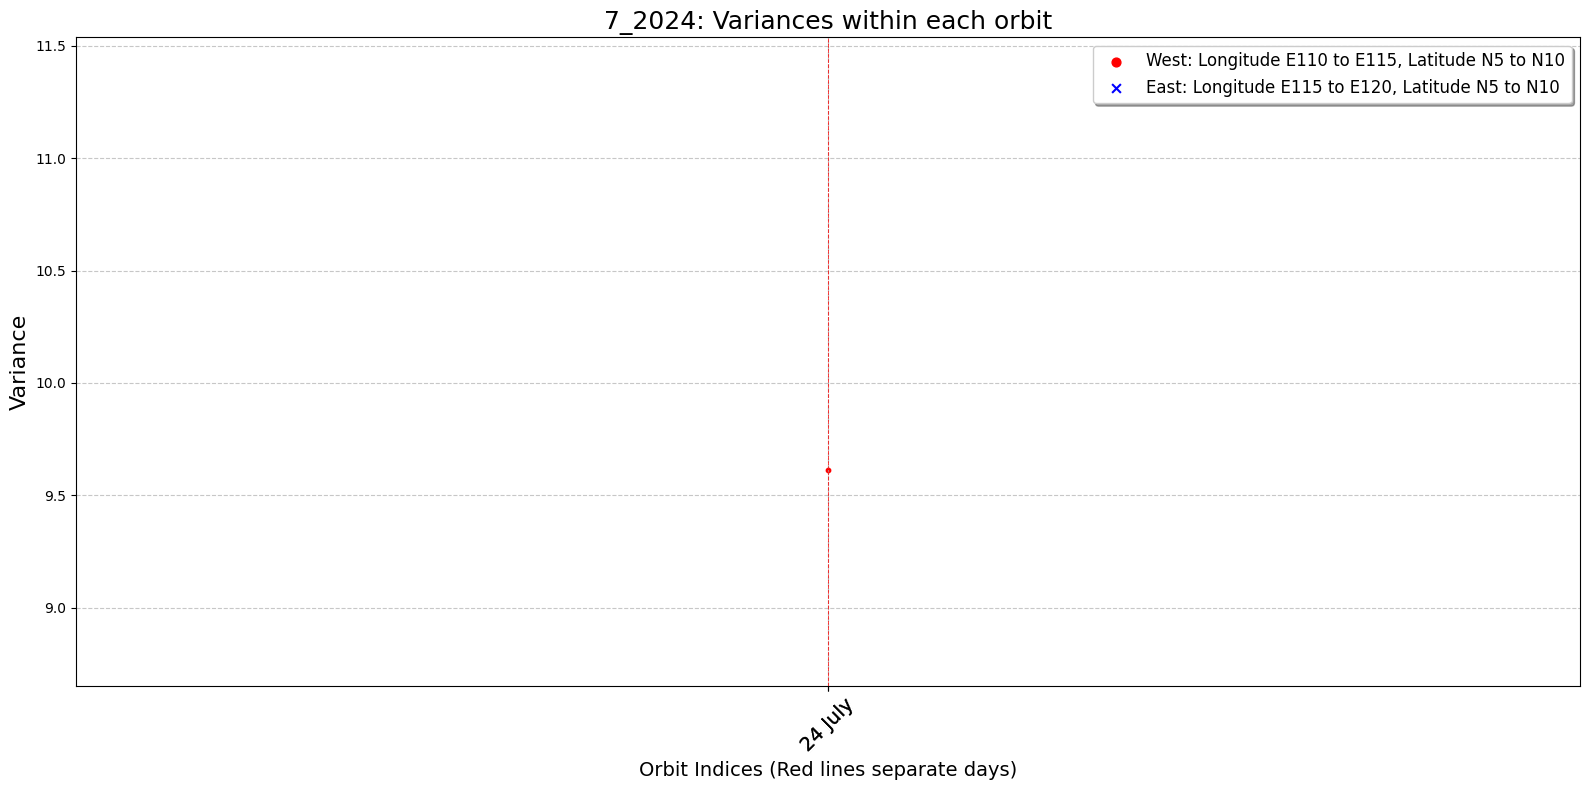

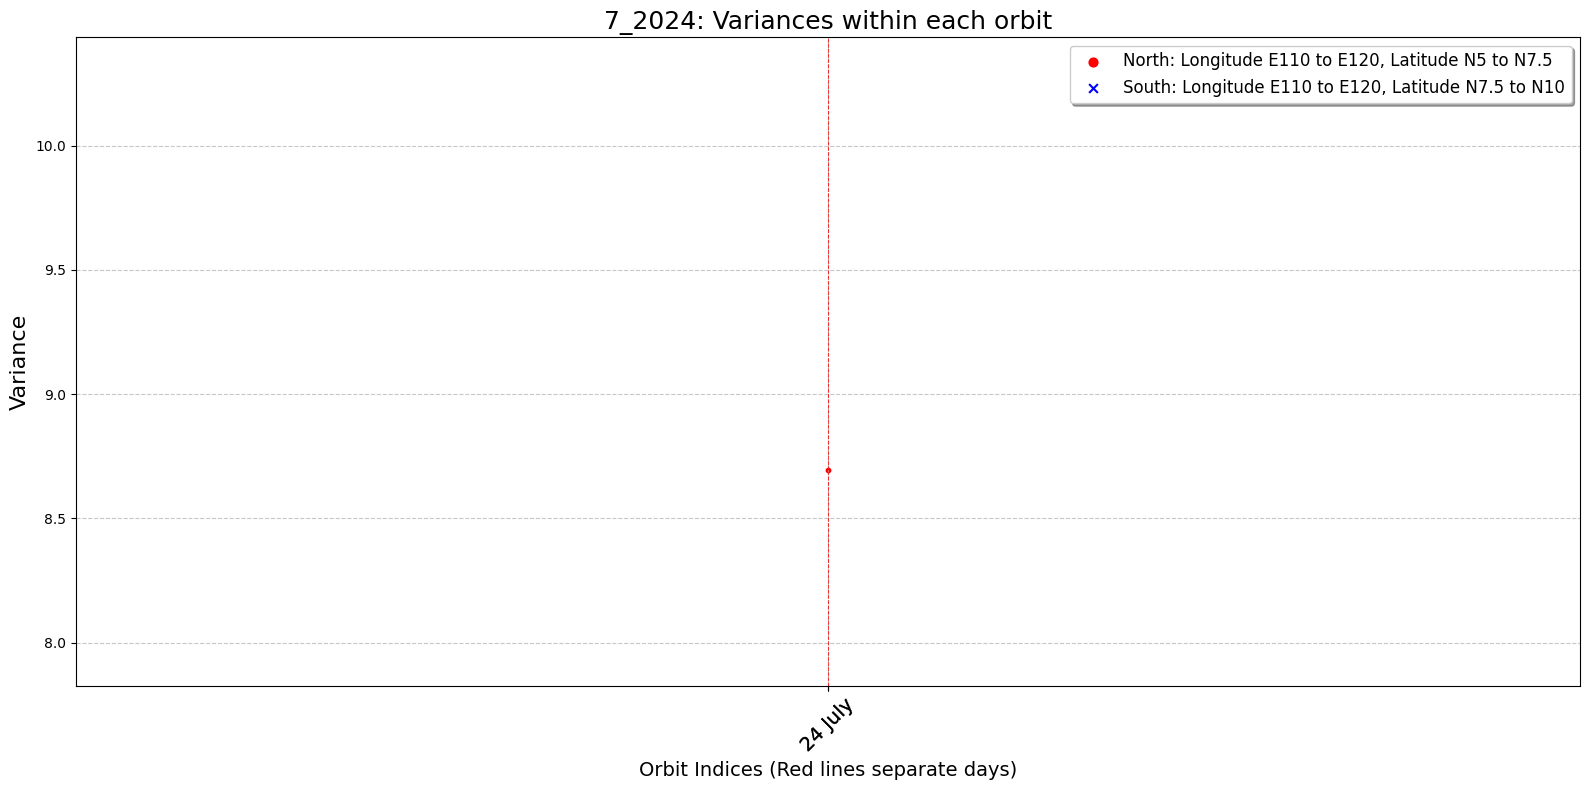

Done


In [79]:
output_dir = r"C:\\Users\\joonw\\TCO\\pipeline_2025\\outputs" # r raw string
os.makedirs(output_dir, exist_ok=True)                        # no error if directory already exist
os.chdir(output_dir)
print(os.getcwd())

for year in ['2024']:
    for month in range(7,8):
        filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
        
        ''' 
        loaded_map should be a hash map that returns dataframe for 'year' and 'month'.
        '''

instance_t = timeseries(analysis_data_map, year, month, output_dir)
instance_t.save_data_plots()
print("Done")

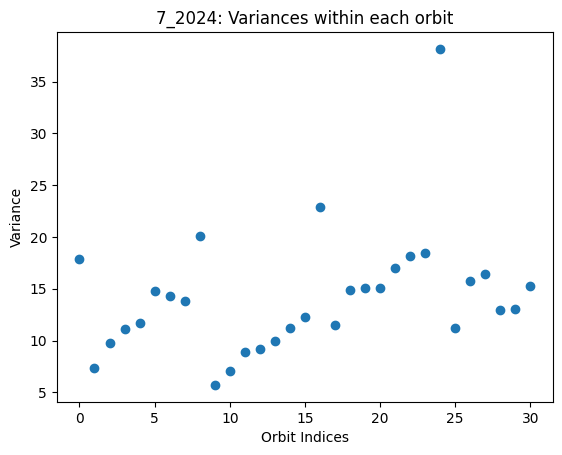

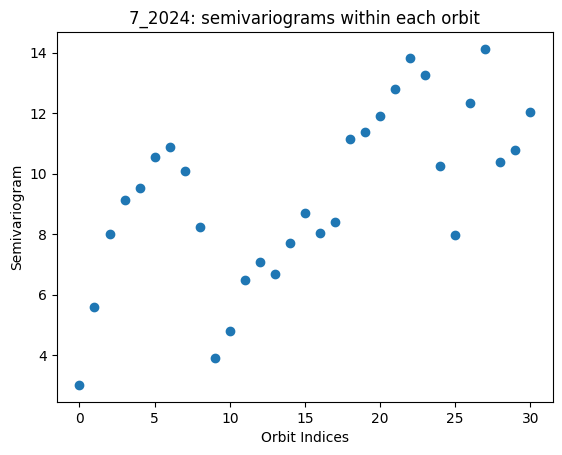

Done


In [86]:
n1 = instance_t.var_timeseries_month()
plt.scatter( range(len(n1)), n1)
plt.xlabel('Orbit Indices') 
plt.ylabel('Variance')
plt.title(f'{month}_{year}: Variances within each orbit')
plt.show()

n2 = instance_t.sem_timeseries_month(sem_lag=0.2, tolerance=0.02)
plt.scatter( range(len(n2)), n2)
plt.xlabel('Orbit Indices')
plt.ylabel('Semivariogram')
plt.title(f'{month}_{year}: semivariograms within each orbit')
plt.show()
print("Done")



In [92]:
import numpy as np
import timeit

def invert_matrix(matrix):
    return np.linalg.inv(matrix)

# Generate a random 800x800 matrix with float64 elements
matrix = np.random.rand(800, 800).astype(np.float64)

# Measure the time taken to invert the matrix
time_taken = timeit.timeit(lambda: invert_matrix(matrix), number=1)

print(f"Time taken to invert the matrix: {time_taken:.6f} seconds")

Time taken to invert the matrix: 0.048004 seconds
